In [1]:
import pandas as pd
import duckdb

In [2]:
con = duckdb.connect()

In [3]:
all_vendors = pd.read_csv("data/clean/user_day_all_vendors.csv")

/var/folders/59/8g5__6px0xdb5h_5y97sbpw80000gn/T/ipykernel_38560/3648988354.py:1: DtypeWarning: Columns (9,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  all_vendors = pd.read_csv("data/clean/user_day_all_vendors.csv")


In [4]:
all_vendors[['steps_clean', 'whoop_strain', 'apple_steps']].notna().sum()

steps_clean     13831
whoop_strain     9193
apple_steps      3945
dtype: int64

Fitbit provided the most consistent daily activity coverage, while Apple Health data was sparse and WHOOP data was intermittent. Analyses therefore treat vendor signals independently rather than assuming completeness.

<Axes: xlabel='steps_clean', ylabel='whoop_strain'>

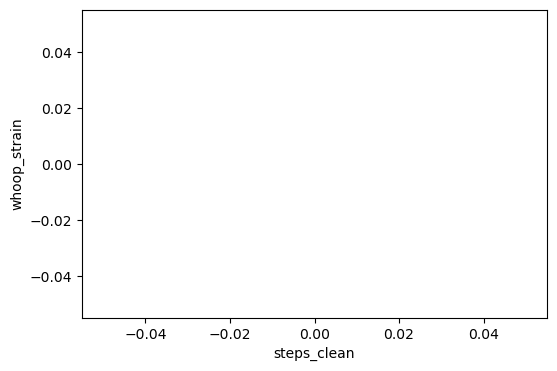

In [7]:
all_vendors.plot.scatter(
    x='steps_clean',
    y='whoop_strain',
    alpha=0.3,
    figsize=(6,4)
)

In [8]:
all_vendors[['steps_clean', 'whoop_strain']].dropna().shape

(0, 2)

Fitbit and WHOOP rarely record on the same calendar day for the same users in this dataset -> correlations are weak or undefined and multi-device fusion is hard.

- models must be vendor-specific

<Axes: xlabel='whoop_strain', ylabel='whoop_recovery'>

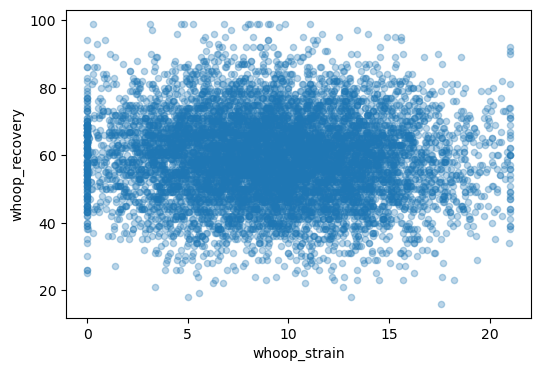

In [9]:
all_vendors.plot.scatter(
    x='whoop_strain',
    y='whoop_recovery',
    alpha=0.3,
    figsize=(6,4)
)

<Axes: xlabel='steps_clean', ylabel='Calories'>

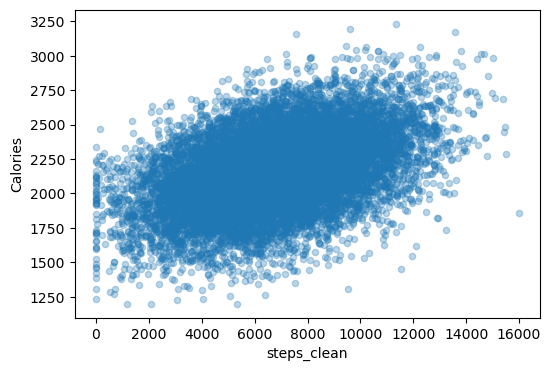

In [10]:
all_vendors.plot.scatter(
    x='steps_clean',
    y='Calories',
    alpha=0.3,
    figsize=(6,4)
)

In [11]:
missing_pct = (
    all_vendors
    .isna()
    .mean()
    .sort_values(ascending=False)
    .rename('missing_pct')
)
missing_pct.head(15)

apple_sleep_minutes      1.000000
apple_resting_hr         0.981771
apple_steps              0.889872
apple_active_energy      0.887778
notes                    0.811401
whoop_sleep_score        0.755932
whoop_hrv                0.750489
whoop_recovery           0.746050
whoop_strain             0.743370
strain_flag_invalid      0.725783
date_3                   0.725783
user_id_3                0.725783
recovery_flag_invalid    0.725783
sleep_flag_invalid       0.725783
hrv_flag_invalid         0.725783
Name: missing_pct, dtype: float64

In [12]:
missing_pct_df = (missing_pct * 100).round(1).reset_index()
missing_pct_df.columns = ['column', 'missing_pct']
missing_pct_df.head(15)

,column,missing_pct
0,apple_sleep_minutes,100.0
1,apple_resting_hr,98.2
2,apple_steps,89.0
3,apple_active_energy,88.8
4,notes,81.1
5,whoop_sleep_score,75.6
6,whoop_hrv,75.0
7,whoop_recovery,74.6
8,whoop_strain,74.3
9,strain_flag_invalid,72.6


- Apple can stay in the dataset for completeness & narrative, but should be excluded from models.
- WHOOP-only models are valid (strain ↔ recovery ↔ HRV), but WHOOP + Fitbit fusion will be sparse.
- will drop flags and duplicated id columns for noise reduction